# Unsupervised Learning Capstone

In [1]:
import pandas as pd
import numpy as np

import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, MiniBatchKMeans, MeanShift, DBSCAN, AffinityPropagation
from sklearn.mixture import GaussianMixture

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Outlier Detection: Identifying Smurf Accounts in League of Legends

League of Legends is the largest videogame in the world with millions of players around the globe. Popular for its competitive and complex game experience, the solo queue ladder is where individual players play to prove their skills. We have assembled data from the North American Solo Queue ladder and will be clustering player accounts by their match histories on the solo queue ladder to identify smurfs: players of high skill impersonating lower rated fake accounts. The smurfs that we find are dominant and single-handedly warp the balance of outcomes of the vast majority of games that they participate in.

Data was collected through the Riot Games API with scripts that you can find in Player_Clustering_Downloads.ipynb and processed and organized with scripts that you can find in Player_Clustering_Downloads.ipynb. Match information is broad in scope and has been distilled down on the account level for each player we will analyze here. The final processed dataset has 179 players pulled from the Silver ranked ladder (3rd lowest rank in the game containing the 20th through 50th percentiles of the playerbase). Each datapoint consists of a single account's aggregate performance statistics from up to 100 solo queue games on the ladder. Accounts that played <20 games total (10 placement games and 10 ladder games) were not considered for this study.

Feature engineering and data cleaning was performed generatively during the construction of this dataset, so we only have features and labels remaining and no missing values. The features we will use to cluster players are all numeric so we start by scaling the values.

In [2]:
df = pd.read_csv('SILVER_Jax\'s Dragons.csv')
df.shape

(179, 23)

In [3]:
df.columns

Index(['Unnamed: 0', 'GamesPlayed', 'WinRate', 'WinGoldDiff', 'WinKP', 'WinDP',
       'WinGoldShare', 'WinDmgShare', 'WinDmgRate', 'WinCSRate', 'WinTime',
       'WinningestRole', 'WinningestChampion', 'LoseGoldDiff', 'LoseKP',
       'LoseDP', 'LoseGoldShare', 'LoseDmgShare', 'LoseDmgRate', 'LoseCSRate',
       'LoseTime', 'LosingestRole', 'LosingestChampion'],
      dtype='object')

In [4]:
df['WinningestRole'].value_counts()

SOLOMID              44
NONEJUNGLE           40
DUO_SUPPORTBOTTOM    38
SOLOTOP              30
DUO_CARRYBOTTOM      27
Name: WinningestRole, dtype: int64

In [50]:
X = df.drop(columns=['Unnamed: 0', 'WinningestRole', 'WinningestChampion', 'LosingestRole', 'LosingestChampion'])

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

## Clustering Algorithms
We will cluster the data with a variety of algorithms to identify the best option. Our goal is to identify outlier groups of unusually consistently high-performing players and distinguish them from the rest of the playerbase nearby on the ladder.

### K-Means

In [6]:
kmeans_cluster = KMeans(n_clusters=3)
%timeit kmeans_cluster.fit(X_std)

30.5 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
centroids = scaler.inverse_transform(kmeans_cluster.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=X.columns)
centroids_df.style.background_gradient(axis=None)

### PCA Feature Reduction and Cluster Visualization

In [8]:
pca = PCA(2)
pca.fit(X_std)
pca_df = pd.DataFrame(pca.transform(X_std), columns=['x1', 'x2'])
pca_df['label'] = kmeans_cluster.labels_
pca_df['WinRate'] = df['WinRate']
pca_df['WinGoldDiff'] = df['WinGoldDiff']
pca_df['WinningestChampion'] = df['WinningestChampion']
pca_df['LosingestChampion'] = df['LosingestChampion']
pca_df['GamesPlayed'] = df['GamesPlayed']

px.scatter(data_frame=pca_df, x='x1', y='x2', color='label', hover_data=['GamesPlayed', 'WinRate', 'WinGoldDiff', 'WinningestChampion', 'LosingestChampion'])

The clusters formed by KMeans are not particularly useful. We can see that our data is not clustered into well-formed cluster shapes, and KMeans performs best when clusters are spherical in form. Let's try DBSCAN - this algorithm is more flexible and can identify irregularly shaped clusters in higher dimensions. 

### DBSCAN and PCA Feature Reduction and Visualization

In [9]:
dbscan_cluster = DBSCAN(eps=5, min_samples=5)
clusters = dbscan_cluster.fit_predict(X_std)

pca = PCA(2)
pca.fit(X_std)
pca_df = pd.DataFrame(pca.transform(X_std), columns=['x1', 'x2'])
pca_df['label'] = clusters
pca_df['WinRate'] = df['WinRate']
pca_df['WinGoldDiff'] = df['WinGoldDiff']
pca_df['WinningestChampion'] = df['WinningestChampion']



px.scatter(data_frame=pca_df, x='x1', y='x2', color='label', hover_data=['WinRate', 'WinGoldDiff', 'WinningestChampion'])

DBSCAN does a better job of identifying some outliers (1 high-winrate Soraka and 1 high-winrate Master Yi player) but the rest of the playerbase is clustered in an unidentifiable form. Since the natural differences between players are wide and our sample size is relatively small, there might be better results with a more computation-based algorithm. Let's try Affinity Propagation and Mean-Shift - both of which seek out local maxima in optimizing relational matrices between datapoints.

### Affinity Propagation

In [51]:
scaled = scaler.fit_transform(X)

In [52]:
sim_mat = -squareform(pdist(scaled))
sim_mat.min() - 1

-16.308529647799684

In [53]:
clst = AffinityPropagation(affinity='precomputed', damping=0.99, verbose=1)
clst.fit(sim_mat)

Converged after 15 iterations.


AffinityPropagation(affinity='precomputed', convergence_iter=15, copy=True,
                    damping=0.99, max_iter=200, preference=None, verbose=1)

In [54]:
cluster_df = X.copy()
cluster_df['label'] = clst.labels_
cluster_df['label'] = 'Cluster ' + cluster_df['label'].astype(str)

In [55]:
cluster_sizes = cluster_df['label'].value_counts().reset_index()
cluster_sizes.columns = ['label', 'count']

In [56]:
exemplar_idxs = clst.cluster_centers_indices_
exemplars = cluster_df.iloc[exemplar_idxs, :]

exemplars = pd.merge(exemplars, cluster_sizes, on='label')

exemplars.sort_values('label').style.background_gradient()

In [57]:
mean_cluster_df = exemplars.groupby('label').mean()
mean_cluster_df.sort_values('label').style.background_gradient()

In [58]:
scaled_exemplars = pd.DataFrame(scaled[exemplar_idxs, :], columns=X.columns)
scaled_exemplars.std()

GamesPlayed      0.716051
WinRate          0.804321
WinGoldDiff      1.680716
WinKP            0.528102
WinDP            0.234781
WinGoldShare     1.006237
WinDmgShare      1.247568
WinDmgRate       1.342180
WinCSRate        0.507009
WinTime          1.285034
LoseGoldDiff     0.812439
LoseKP           0.477766
LoseDP           1.909662
LoseGoldShare    0.157569
LoseDmgShare     0.764495
LoseDmgRate      0.868252
LoseCSRate       0.752629
LoseTime         1.162914
dtype: float64

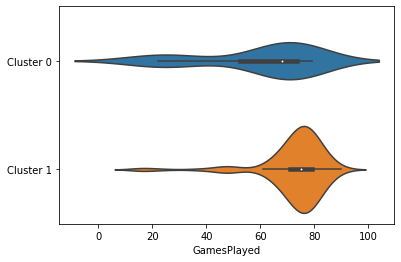

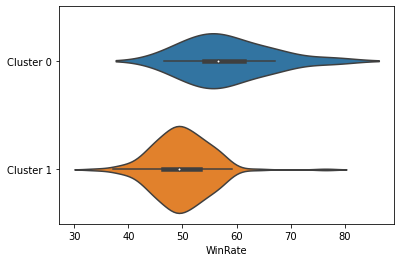

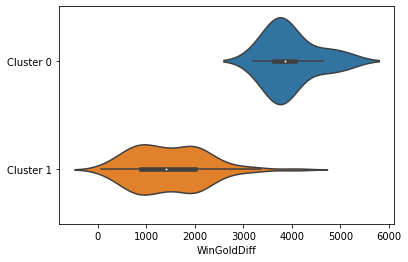

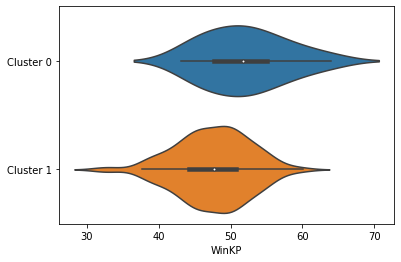

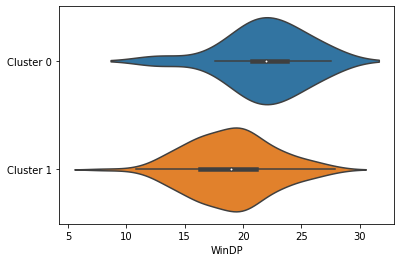

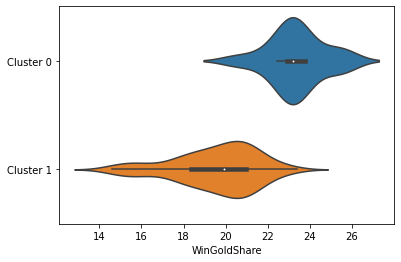

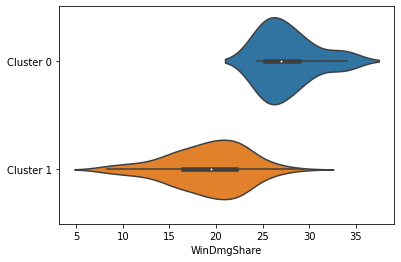

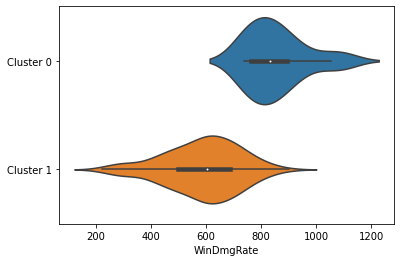

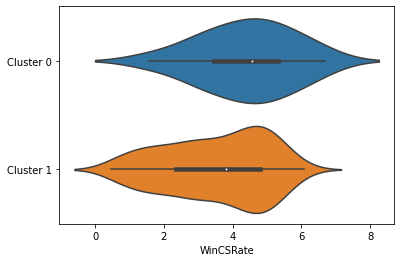

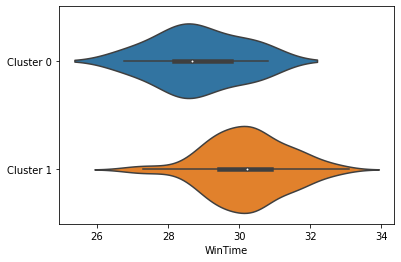

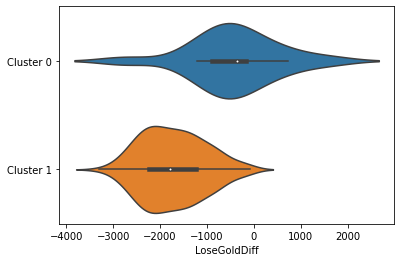

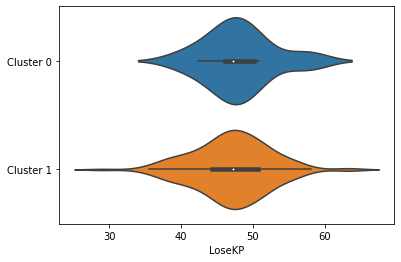

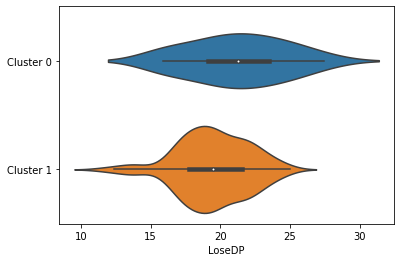

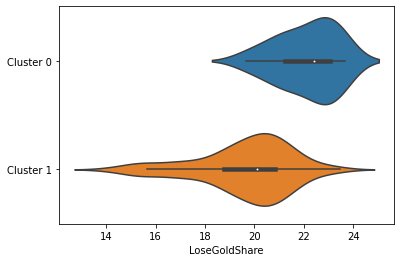

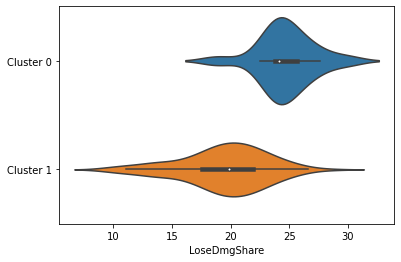

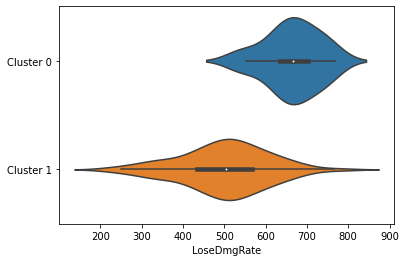

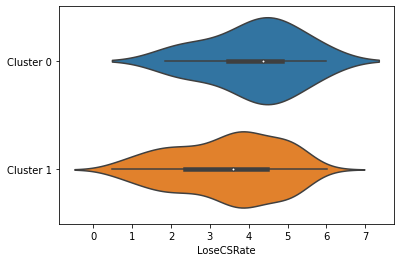

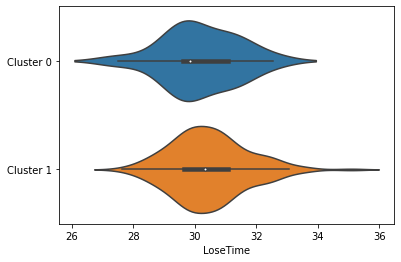

In [59]:
plot_cluster_df = cluster_df.copy()

for c in X.columns:
    plot_df = cluster_df[['label', c]]
    plot_df = plot_df.sort_values('label')
    sns.violinplot(c, 'label', data=plot_df)
    plt.ylabel('')
    plt.xlabel(c)
    plt.show()

In [60]:
pca = PCA(2)
pca.fit(X_std)
pca_df = pd.DataFrame(pca.transform(X_std), columns=['x1', 'x2'])
pca_df['label'] = clst.labels_
pca_df['WinRate'] = df['WinRate']
pca_df['WinGoldDiff'] = df['WinGoldDiff']
pca_df['WinningestChampion'] = df['WinningestChampion']

px.scatter(data_frame=pca_df, x='x1', y='x2', color='label', hover_data=['WinRate', 'WinGoldDiff', 'WinningestChampion'])

Affinity Propagation does a much better job identifying clusters of players based on performance. We see cluster 0 has a reliably high level of performance, but on a variety of levels of results. It is clear that they consistently perform better than cluster 1, but it is not yet enough of a difference to justify labeling these players as smurfs. This cluster appears to simply be better players on the ladder, but not to the level of abusively warping the quality of the games.

Let's try factor analysis to cluster our features into categories before applying the Mean-Shift algorithm to identify clusters.

### Factor Analysis Feature Clustering

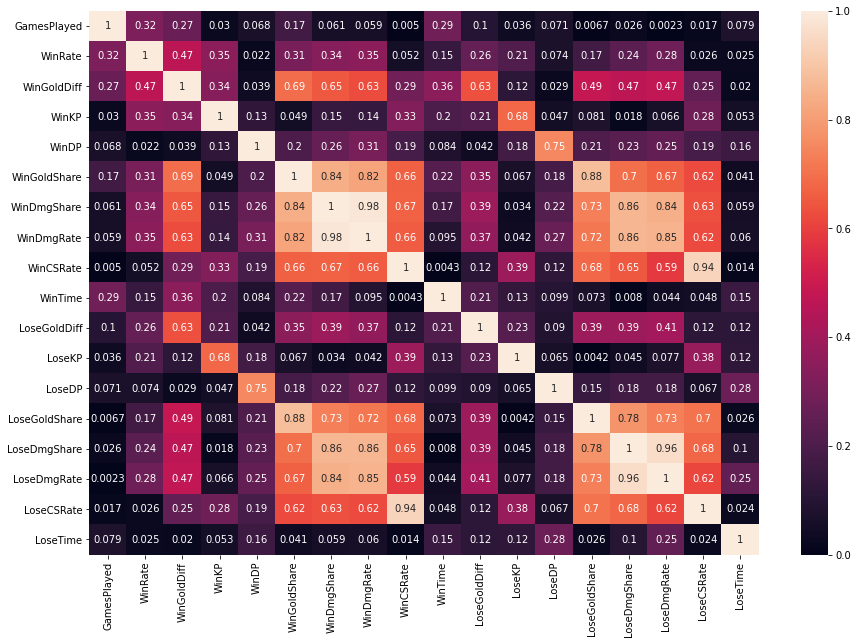

In [20]:
# Examing correlated features
# Unsurprisingly, our performance metrics are highly correlated and Gold and Damage interact with one another in game.

scaled_df = pd.DataFrame(scaled, index=X.index, columns=X.columns)

plt.figure(figsize=(15, 10))
sns.heatmap(scaled_df.corr().abs(), vmin=0, vmax=1, annot=True)
plt.show()

In [21]:
# Tests to determine whether factor analysis is appropriate for our feature space

_, p_value = calculate_bartlett_sphericity(scaled)
print(
    f"* Passed Bartlett adequacy test?\n\tp_value < 0.05? {p_value < 0.05} (p = {p_value:.4f})"
)

_, kmo = calculate_kmo(scaled)
print(
    f"* Passed Kaiser-Meyer-Olkin adequacy test?\n\tkmo >= 0.6? {kmo >= 0.6} (kmo = {kmo:.4f})"
)

* Passed Bartlett adequacy test?
	p_value < 0.05? True (p = 0.0000)
* Passed Kaiser-Meyer-Olkin adequacy test?
	kmo >= 0.6? True (kmo = 0.6968)


/opt/anaconda3/envs/thinkful/lib/python3.7/site-packages/factor_analyzer/utils.py:248: UserWarning:

The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.



In [22]:
fa = FactorAnalyzer(n_factors=25, rotation="varimax")
_ = fa.fit_transform(scaled)
ev, _ = fa.get_eigenvalues()

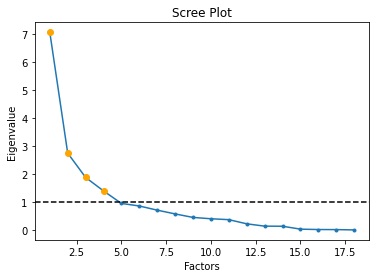

In [23]:
# Determine the ideal number of eigenvalues for factor analysis by generating a scree plot
# Eigenvalues greater than 1 are considered significant feature groupings

# Plot eigenvalues as a scree plot
idx = range(1, len(ev) + 1)
plt.plot(idx, ev, marker=".")

# Highlight points above threshold value of 1
ev_above_thresh = ev[np.where(ev > 1)]
idx = range(1, len(ev_above_thresh) + 1)
plt.scatter(idx, ev_above_thresh, c="orange", zorder=5)

# Plot threshold of 1
plt.axhline(y=1, c="black", linestyle="--")

# Pretty up
plt.title("Scree Plot")
plt.xlabel("Factors")
plt.ylabel("Eigenvalue")
plt.show()

In [24]:
# Factor Analysis with 4 eigenvalues boils our 18 features down to 4 underlying attributes

fa = FactorAnalyzer(n_factors=4, rotation="varimax")
factors = fa.fit_transform(scaled)

print(scaled.shape)
print(factors.shape)

(179, 18)
(179, 4)


In [25]:
# Inspecting factors generated

loadings = pd.DataFrame(fa.loadings_)
loadings.index = X.columns
loadings.columns = [f"factor_{i}" for i in range(loadings.shape[1])]

# Sort by absolute value of column
sort_order = loadings.abs().sort_values("factor_0", ascending=False).index
loadings = loadings.reindex(sort_order)

print("Factor loadings values (colored by value)")
loadings.abs().style.background_gradient(axis=None)

Factor loadings values (colored by value)


Our 4 factors generated are distinguishable in a way that makes sense in the game. The first factor I will call 'carry factor': these are players that (regardless of winning or losing) find a way to generate gold, deal damage, and farm minions. The second factor I will call the 'scrappers': these are players that (regardless of winning or losing) find ways to join fights both to contribute to team kills but also to die to the enemy team. The third factor I will call 'damage monsters': these are players that (regardless of win or loss) deal a significantly large portion of their team's damage; they are the biggest threats on their teams in every game. The fourth factor I will call 'lane bully': these are players that outperform their direct matchup opponent on the enemy team and consistently generate gold leads by dominating their matchup.

Here we arrange our original dataset into these underlying factors.

In [26]:
factors_columns = {
    'factor_0': 'Carry_Factor',
    'factor_1': 'Scrapper',
    'factor_2': 'Damage_Monster',
    'factor_3': 'LaneBully'
}

lol_factors_df = pd.DataFrame(factors, columns=factors_columns, index=X.index)
lol_factors_df = lol_factors_df.rename(columns=factors_columns)
lol_factors_df

Carry_Factor  Scrapper  Damage_Monster  LaneBully
0        0.099547  1.505595        0.634891  -1.676791
1       -1.388322  0.705299        2.100144   1.558330
2        0.415461  0.437695        0.830632   0.024399
3        0.413215 -1.115233        0.884388  -0.315702
4        1.515599 -0.430013        0.873446   0.644806
..            ...       ...             ...        ...
174      0.670629 -0.624986       -0.446734  -0.678197
175     -2.073357 -0.016045        0.386565   0.161959
176     -0.521928  1.185778        1.433536  -0.144199
177      0.267181 -2.018167       -0.936305   2.288320
178     -2.101415  0.384617       -0.460676  -0.110161

[179 rows x 4 columns]

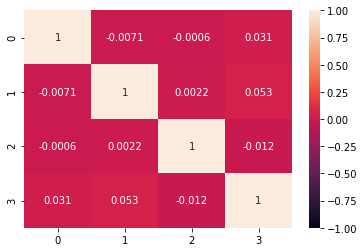

In [27]:
# Show that our new factors are completely uncorrelated from each other

factors_df = pd.DataFrame(factors)
sns.heatmap(factors_df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

## Mean-Shift Data Clustering

In [28]:
# Scale our new factor feature space and apply Mean-Shift algorithm

scaled = scaler.fit_transform(lol_factors_df)

mean_shift = MeanShift(bandwidth=2)
mean_shift.fit(scaled)

MeanShift(bandwidth=2, bin_seeding=False, cluster_all=True, max_iter=300,
          min_bin_freq=1, n_jobs=None, seeds=None)

In [29]:
# Show the generated clusters' attributes in terms of the underlying generalized factors

unscaled_centers = scaler.inverse_transform(mean_shift.cluster_centers_)
cluster_centers = pd.DataFrame(unscaled_centers, columns=lol_factors_df.columns)
cluster_centers = cluster_centers.sort_values("LaneBully")
cluster_centers.style.background_gradient(axis=0)

Since scrapper and damage_monster have some relationship with the role that a given player chooses, our most interesting factors are LaneBully and Carry_Factor. These both indicate players that consistently perform at a high level and manage to influece the game in a tangible advantage in the majority of games. For that reason, we are interested in further evaluating cluster 1.

In [30]:
cluster_analysis = df.copy()
cluster_analysis["label"] = mean_shift.labels_.astype(str)
cluster_analysis["label"] += "_"

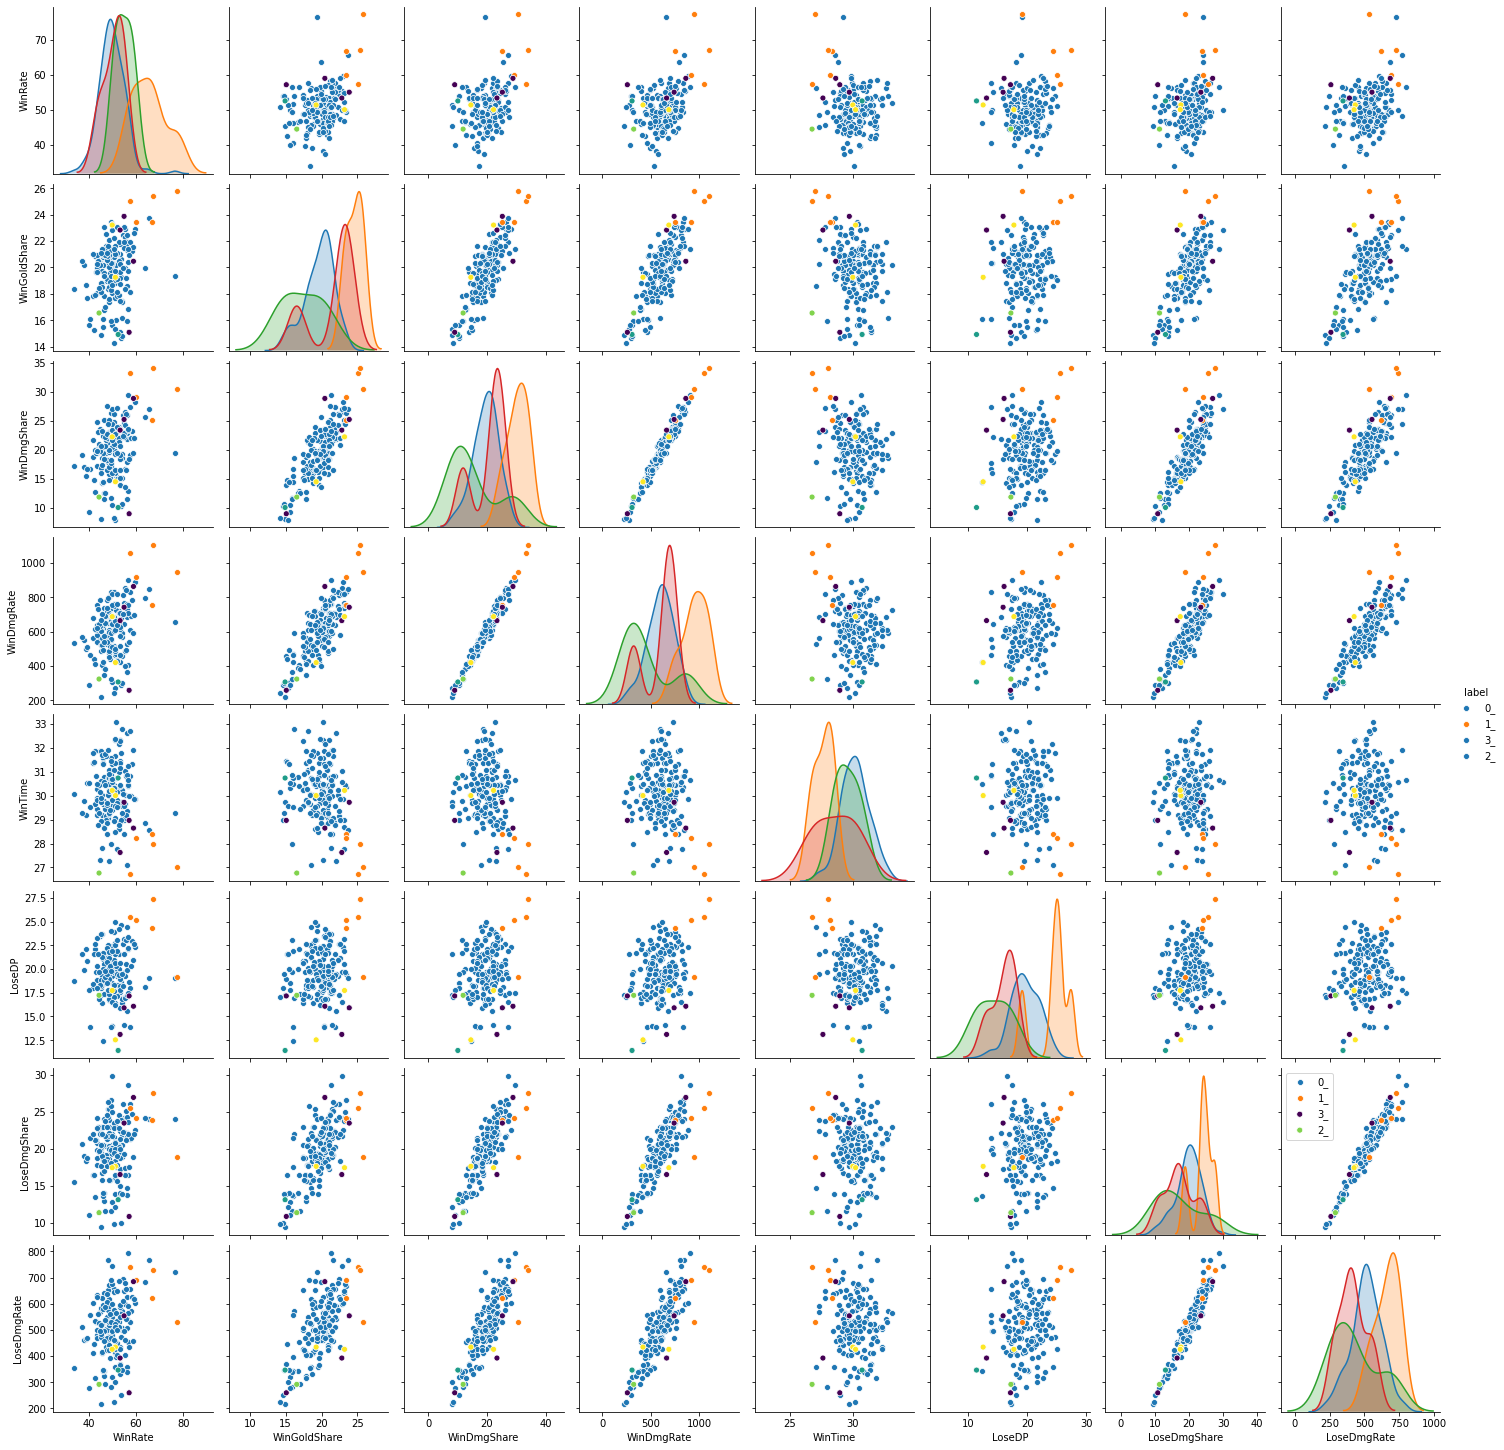

In [35]:
sns.pairplot(cluster_analysis, vars=['WinRate', 'WinGoldShare', 'WinDmgShare', 'WinDmgRate', 'WinTime', 'LoseDP', 'LoseDmgShare', 'LoseDmgRate'], hue="label")
plt.legend()
plt.show()

The above pairplot tells the entire story. Mean-Shift has not sorted every single player into a cluster, but our primary goal was not to organize the entire playerbase but to identify the players that fit the smurf account description. Cluster 1, the cluster of interest we identified from our factor profile, is plotted in orange in the above pairplot. We see that this population of players is staggeringly dominant and entirely stand apart from the rest of the ladder. These players dominate their team's damage rates, and earn massive amounts of gold regardless of whether they are winning or losing, and they win extremely quickly.

We inspect these clustered players directly below.

In [43]:
pd.options.display.max_columns = None

display(cluster_analysis.loc[cluster_analysis['label'] == '1_'])

Unnamed: 0  GamesPlayed  WinRate  WinGoldDiff      WinKP  \
8        Chimp Slayer           22    77.27  4639.235294  63.973529   
9    14weedandanime88           68    57.35  4856.487179  54.602564   
81     WHITEDEVIL9000           30    66.67  3917.050000  46.668000   
133   stonerplayT33M0           65    60.00  3981.666667  52.925385   
151         NOOBSLOSE           70    67.14  5178.319149  56.556170   

         WinDP  WinGoldShare  WinDmgShare   WinDmgRate  WinCSRate    WinTime  \
8    20.915882     25.762941    30.479412   947.460588   1.566471  27.032353   
9    26.667692     25.035641    33.324359  1054.884103   5.356410  26.743846   
81   20.235500     23.435000    25.155000   754.006500   6.681000  28.379500   
133  22.595897     23.446667    29.144872   918.191026   2.906154  28.212564   
151  27.507021     25.383830    34.080851  1104.097872   4.871064  27.993191   

    WinningestRole WinningestChampion  LoseGoldDiff     LoseKP     LoseDP  \
8       NONEJUNGLE           MasterYi   -690.800000  47.320000  19.140000   
9          SOLOMID         Cassiopeia   1567.206897  50.318276  25.490690   
81         SOLOTOP             Irelia  -2727.200000  50.135000  24.361000   
133     NONEJUNGLE             LeeSin   -852.500000  47.113846  25.121154   
151        SOLOMID              Yasuo   -328.304348  43.426957  27.413478   

     LoseGoldShare  LoseDmgShare  LoseDmgRate  LoseCSRate   LoseTime  \
8        20.296000     18.896000   531.728000    1.834000  28.830000   
9        23.490000     25.487931   740.222069    3.950345  29.664828   
81       20.853000     23.870000   621.199000    5.295000  29.808000   
133      21.094231     24.171538   689.961923    2.519231  29.633462   
151      22.329130     27.609565   727.245652    4.887391  29.518261   

    LosingestRole LosingestChampion label  
8      NONEJUNGLE            Rengar    1_  
9         SOLOMID        Tryndamere    1_  
81        SOLOMID             Akali    1_  
133    NONEJUNGLE            LeeSin    1_  
151       SOLOMID          Kassadin    1_

As expected, these accounts are easily identifiable smurf accounts. Their winrates are absurdly high and their performance is exceptional. It is also important to note the roles and the champions that these players play. We have a Master Yi Jungler, a Cassiopeia Mid, an Irelia Top, a Lee Sin Jungler, and a Yasuo Mid. If you are familiar with the game this makes sense to you. If you are not familiar with the game, the best way to explain this collection of champions and roles is that they are exceedingly difficult to play on an execution level, they are very self-sufficient and can impact the game without any cooperation or setup from their teammates, and they require coordinated efforts for counterplay from the enemy team to counteract their strengths. In the low ranks of silver, it is clear that successful pilots of these champions come from a much higher rank in the ladder and they are simply tourists in the lower brackets to dominate low skilled players for fun. It is impossible to know how high the true ranks of these 5 players is without further analysis and modeling.

<Figure size 1080x1080 with 0 Axes>

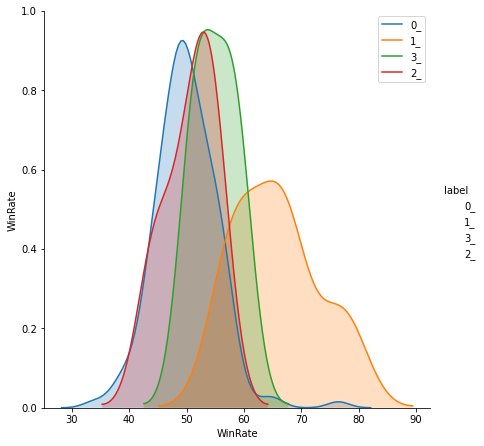

In [65]:
plt.figure(figsize=(15,15))
sns.pairplot(cluster_analysis, vars=['WinRate'], hue="label", height=6)
plt.legend()
plt.show()

<Figure size 1080x1080 with 0 Axes>

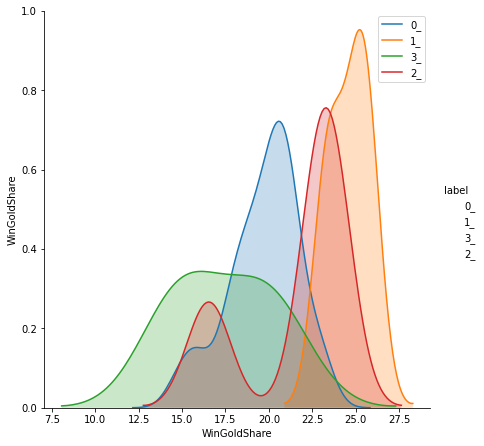

In [66]:
plt.figure(figsize=(15,15))
sns.pairplot(cluster_analysis, vars=['WinGoldShare'], hue="label", height=6)
plt.legend()
plt.show()

<Figure size 1080x1080 with 0 Axes>

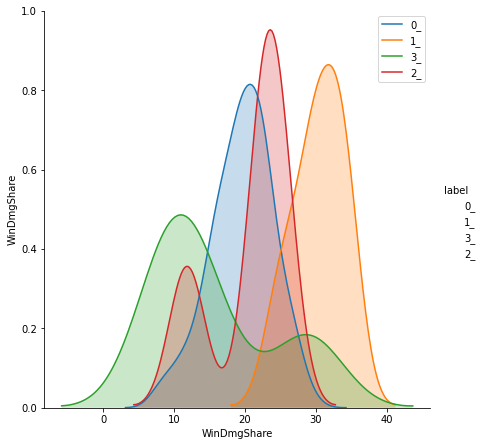

In [67]:
plt.figure(figsize=(15,15))
sns.pairplot(cluster_analysis, vars=['WinDmgShare'], hue="label", height=6)
plt.legend()
plt.show()

<Figure size 1080x1080 with 0 Axes>

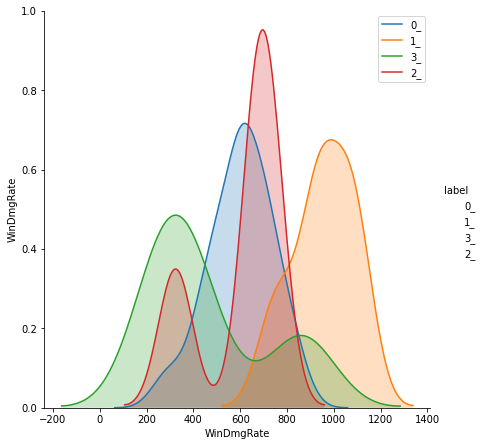

In [68]:
plt.figure(figsize=(15,15))
sns.pairplot(cluster_analysis, vars=['WinDmgRate'], hue="label", height=6)
plt.legend()
plt.show()

<Figure size 1080x1080 with 0 Axes>

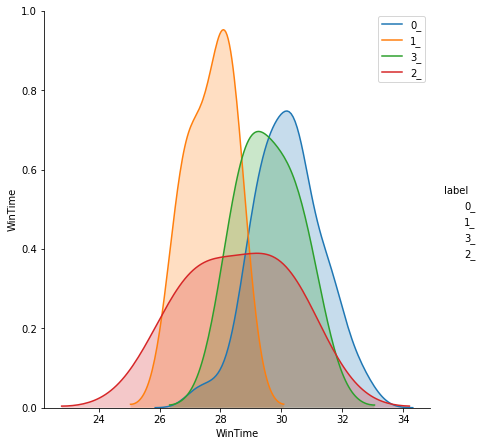

In [72]:
plt.figure(figsize=(15,15))
sns.pairplot(cluster_analysis, vars=['WinTime'], hue="label", height=6)
plt.legend()
plt.show()

<Figure size 1080x1080 with 0 Axes>

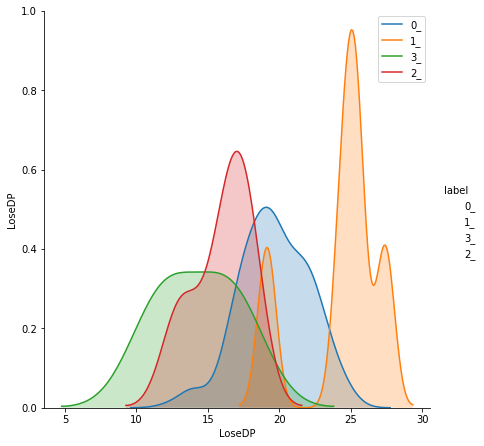

In [69]:
plt.figure(figsize=(15,15))
sns.pairplot(cluster_analysis, vars=['LoseDP'], hue="label", height=6)
plt.legend()
plt.show()

<Figure size 1080x1080 with 0 Axes>

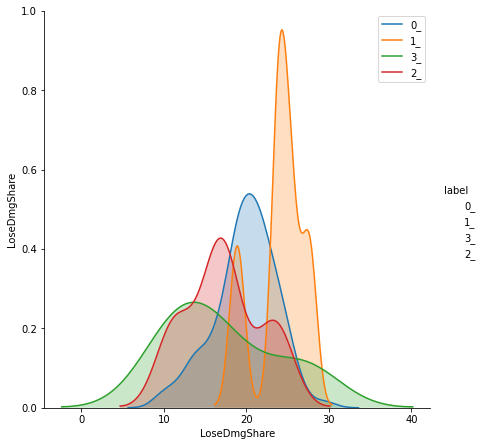

In [71]:
plt.figure(figsize=(15,15))
sns.pairplot(cluster_analysis, vars=['LoseDmgShare'], hue="label", height=6)
plt.legend()
plt.show()

<Figure size 1080x1080 with 0 Axes>

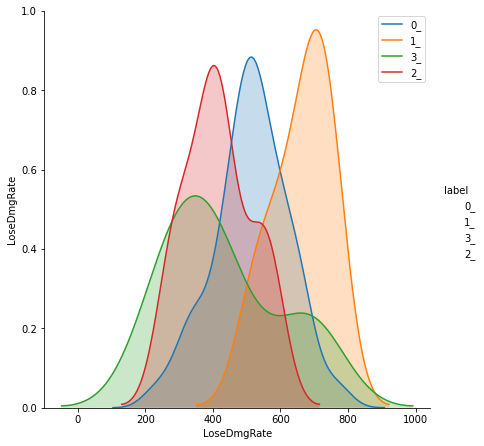

In [70]:
plt.figure(figsize=(15,15))
sns.pairplot(cluster_analysis, vars=['LoseDmgRate'], hue="label", height=6)
plt.legend()
plt.show()

In [81]:
df['LoseDmgShare'].mean()

19.883430378056385